In [39]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df = pd.read_json('file_01.json')

In [41]:
cols = {
  'id клиента':'client_id',
  'id счета':'account_id',
  'Дата рождения':'birthdate',
  'Пол' : 'sex',
  'Клиент подключил услугу' : 'activate_service',
  'Клиент отключил услугу':'deactivate_service'
}

df = df.rename(columns = cols)

In [42]:
df['activate_service'] = pd.to_datetime(df['activate_service'])
df['deactivate_service']  = pd.to_datetime(df['deactivate_service'])
df['month_activate']  = df['activate_service'].dt.to_period('M')
df['month_deactivate']   = df['deactivate_service'].dt.to_period('M')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1364
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           1365 non-null   int64         
 1   account_id          1365 non-null   int64         
 2   birthdate           1365 non-null   object        
 3   sex                 1362 non-null   float64       
 4   activate_service    1365 non-null   datetime64[ns]
 5   deactivate_service  1182 non-null   datetime64[ns]
 6   month_activate      1365 non-null   period[M]     
 7   month_deactivate    1182 non-null   period[M]     
dtypes: datetime64[ns](2), float64(1), int64(2), object(1), period[M](2)
memory usage: 96.0+ KB


In [44]:
df.head()

,client_id,account_id,birthdate,sex,activate_service,deactivate_service,month_activate,month_deactivate
0,1236,3000,1976-11-02,0.0,2020-09-22 19:36:56,2021-09-10 19:24:19,2020-09,2021-09
1,1314,3001,1979-10-21,1.0,2020-04-29 11:13:18,NaT,2020-04,NaT
2,1248,3002,1964-11-15,1.0,2020-09-30 14:48:46,2021-04-30 10:26:50,2020-09,2021-04
3,2053,3003,1979-09-12,0.0,2020-03-03 17:10:30,2020-09-10 16:19:03,2020-03,2020-09
4,2016,3004,1973-03-23,0.0,2019-08-19 13:24:27,2019-11-28 15:49:09,2019-08,2019-11


# Подключения и отключения

In [45]:
#подписки по месяцам
df_activations = \
    df.groupby(df['month_activate']). \
    agg({'activate_service':'count'}). \
    sort_values('month_activate'). \
    rename(columns={'activate_service':'amount_activations'})

In [46]:
#отписки по месяцам
df_deactivations = \
    df.groupby(df['month_deactivate']). \
    agg({'deactivate_service':'count'}). \
    sort_values('month_deactivate'). \
    rename(columns={'deactivate_service':'amount_deactivations'})

Text(0, 0.5, 'Подключения')

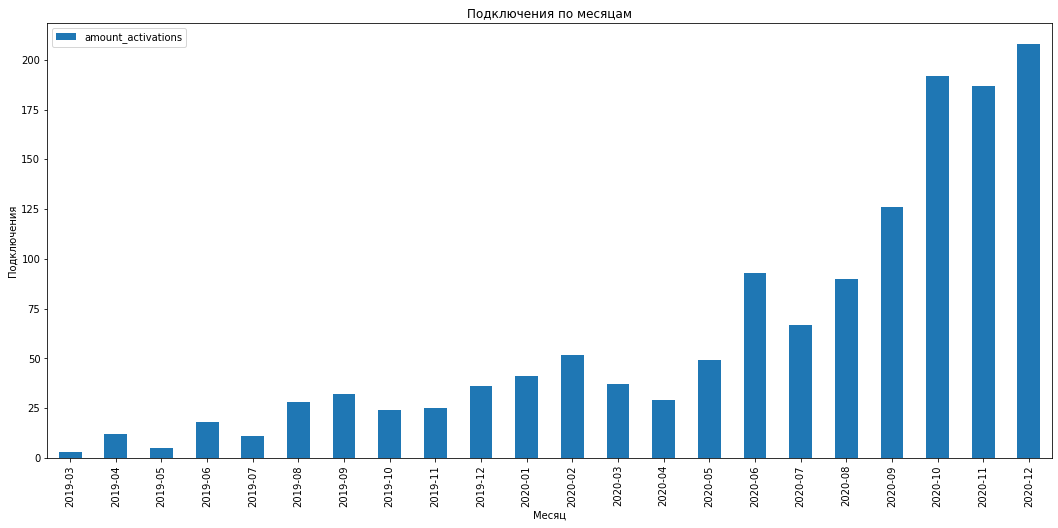

In [47]:
fig = df_activations.plot.bar(figsize=(18,8))
fig.set_title('Подключения по месяцам')
fig.set_xlabel('Месяц')
fig.set_ylabel('Подключения')

Text(0, 0.5, 'Отключения')

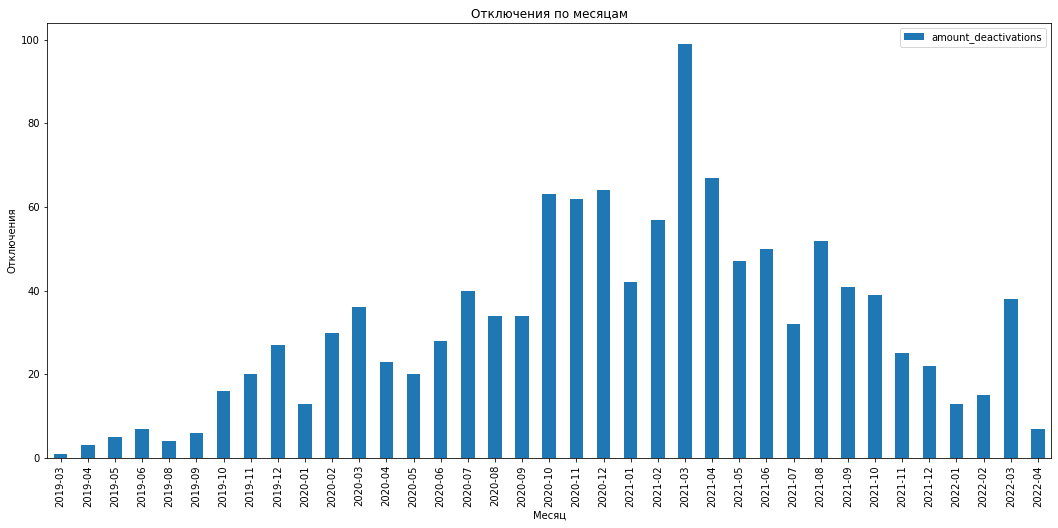

In [48]:
fig = df_deactivations.plot.bar(figsize=(18,8))
fig.set_title('Отключения по месяцам')
fig.set_xlabel('Месяц')
fig.set_ylabel('Отключения')

In [49]:
#датафрейм с подписками и отписками
df_activations_deactivations = df_deactivations.join(df_activations, how='outer')
# df_activations_deactivations.head(10)

Text(0, 0.5, 'Количество')

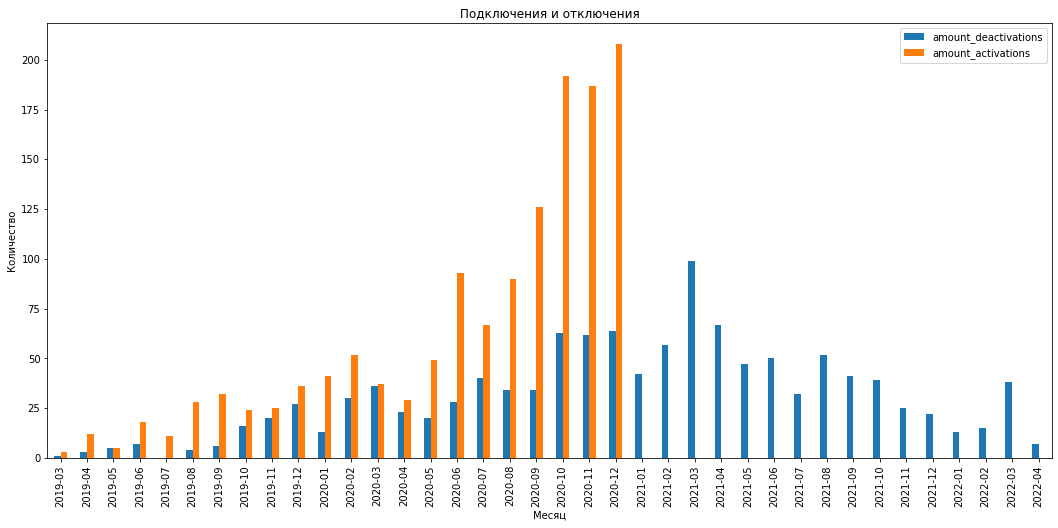

In [50]:
fig = df_activations_deactivations.plot.bar(figsize=(18,8))
fig.set_title('Подключения и отключения')
fig.set_xlabel('Месяц')
fig.set_ylabel('Количество')

In [51]:
# Сальдо подключений/отключений
df_activations_deactivations = df_activations_deactivations.fillna(0)
df_activations_deactivations['saldo'] = \
  df_activations_deactivations['amount_activations'] - df_activations_deactivations['amount_deactivations']

In [52]:
df_activations_deactivations.tail()

,amount_deactivations,amount_activations,saldo
2021-12,22.0,0.0,-22.0
2022-01,13.0,0.0,-13.0
2022-02,15.0,0.0,-15.0
2022-03,38.0,0.0,-38.0
2022-04,7.0,0.0,-7.0


Text(0, 0.5, 'Количество')

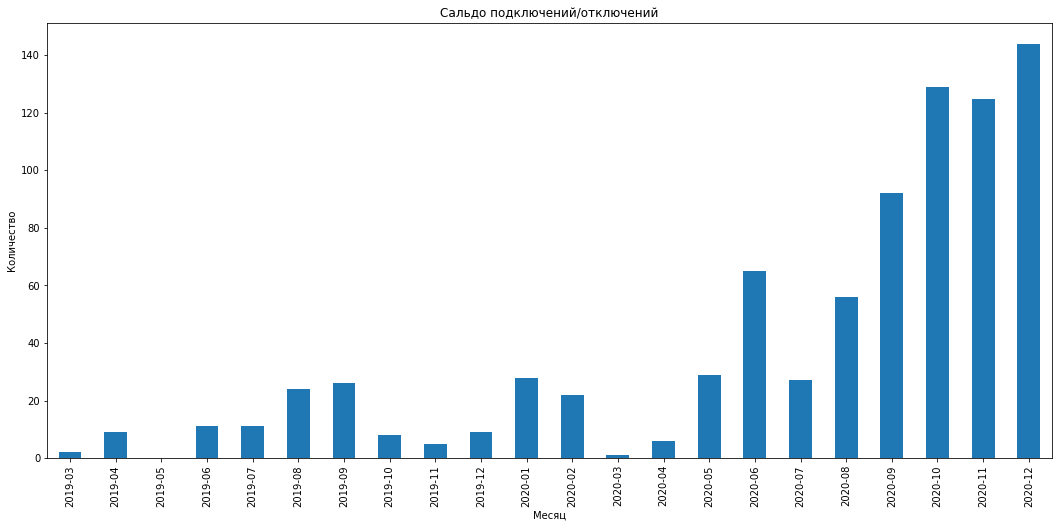

In [53]:
fig = df_activations_deactivations.loc[df_activations_deactivations.index<'2021-01'].saldo.plot.bar(figsize=(18,8))
fig.set_title('Сальдо подключений/отключений')
fig.set_xlabel('Месяц')
fig.set_ylabel('Количество')

# Прогнозирование подписок/отписок

In [54]:
# Берем средний прирост подписок за 2020
mean_activations_2020 = (df_activations - df_activations.shift(1))[-12:].mean()[0]
mean_activations_2020

14.333333333333334

In [55]:
# Берем средний прирост отписок за 2020
df_deactivations_2020 = df_deactivations.loc[df_deactivations.index < '2021-01']
mean_deactivations_2020 = (df_deactivations_2020 - df_deactivations_2020.shift(1))[-12:].mean()[0]
mean_deactivations_2020

3.0833333333333335

In [56]:
# Ради интереса посмотрели показатель за 2021 по отпискам
df_deactivations_2021 = df_deactivations.loc[(df_deactivations.index >= '2020-12') & (df_deactivations.index < '2022-01')]
mean_deactivations_2021 = (df_deactivations_2021 - df_deactivations_2021.shift(1))[-12:].mean()[0] #.mean(skipna=True)
mean_deactivations_2021

-3.5

In [57]:
df_forecast = df_activations_deactivations
df_forecast.tail()

,amount_deactivations,amount_activations,saldo
2021-12,22.0,0.0,-22.0
2022-01,13.0,0.0,-13.0
2022-02,15.0,0.0,-15.0
2022-03,38.0,0.0,-38.0
2022-04,7.0,0.0,-7.0


In [58]:
df_forecast.loc[-16:, 'amount_activations'] = \
  df_forecast.loc['2020-12', 'amount_activations'] + \
  np.array(range(1,17)) * mean_activations_2020

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
df_forecast.loc[-16:, 'amount_deactivations'] = \
  df_forecast.loc['2020-12', 'amount_deactivations'] + \
  np.array(range(1,17)) * mean_deactivations_2020

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
df_forecast['saldo'] = df_forecast['amount_activations'] - df_forecast['amount_deactivations']

Text(0, 0.5, 'Количество')

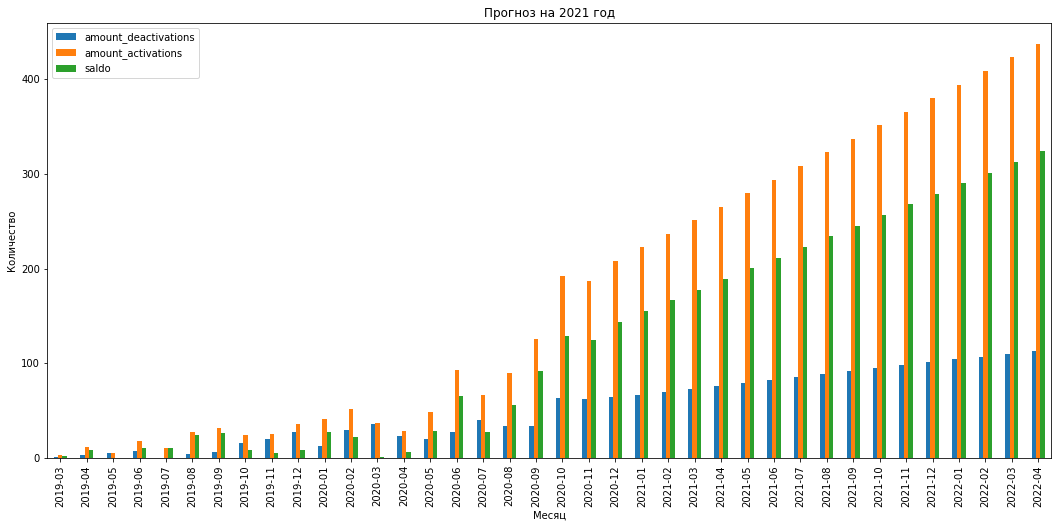

In [61]:
fig = df_forecast.plot.bar(figsize=(18,8))
fig.set_title('Прогноз на 2021 год')
fig.set_xlabel('Месяц')
fig.set_ylabel('Количество')

In [ ]:
# Берем средний прирост сальдо за последний полгода
# df_saldo_2020 = df_activations_deactivations.loc[
#   (df_activations_deactivations.index >= '2020-01') &
#   (df_activations_deactivations.index < '2021-01')
# ]

# (df_saldo_2020.saldo - df_saldo_2020.saldo.shift(1)).mean()

In [ ]:
# df_activations_deactivations = df_deactivations.join(df_activations, how='outer')

In [ ]:
df.head()

,client_id,account_id,birthdate,sex,activate_service,deactivate_service,month_activate,month_deactivate
0,1236,3000,1976-11-02,0.0,2020-09-22 19:36:56,2021-09-10 19:24:19,2020-09,2021-09
1,1314,3001,1979-10-21,1.0,2020-04-29 11:13:18,NaT,2020-04,NaT
2,1248,3002,1964-11-15,1.0,2020-09-30 14:48:46,2021-04-30 10:26:50,2020-09,2021-04
3,2053,3003,1979-09-12,0.0,2020-03-03 17:10:30,2020-09-10 16:19:03,2020-03,2020-09
4,2016,3004,1973-03-23,0.0,2019-08-19 13:24:27,2019-11-28 15:49:09,2019-08,2019-11


# Портрет пользователя

In [62]:
# Проверка на противоречия в данных
assert df[['client_id','sex','birthdate']].drop_duplicates().shape[0] == \
  df[['client_id']].drop_duplicates().shape[0]

In [66]:
# Агрегация с вычислением количетсва счетов и количества подклюений на пользователя
df_clients = df \
  .groupby('client_id') \
  .agg({'account_id':'nunique',
        'birthdate':'max',
        'sex':'max',
        'activate_service':'nunique'
        })

In [67]:
# Расчет возраста
df_clients['age'] = (pd.Timestamp('now') - pd.to_datetime(df_clients['birthdate'])).astype('timedelta64[Y]').astype('int')

In [68]:
# Взглянули на максимальное количетсво подключений услуг среди пользователей
df_clients.sort_values('activate_service', ascending=False).head(3)

,account_id,birthdate,sex,activate_service,age
client_id,,,,,
1716,6,1964-08-27,0.0,22,57
2028,4,1967-01-31,0.0,7,55
1486,1,1998-11-19,1.0,7,23


In [69]:
# Взглянули на самых возрастных клиентов
df_clients.sort_values('age', ascending=False).head(3)

,account_id,birthdate,sex,activate_service,age
client_id,,,,,
2055,1,1931-02-20,0.0,1,91
1001,1,1934-08-09,0.0,1,87
2127,1,1937-02-09,1.0,1,85


In [ ]:
# Cредний возраст клиента
df_clients['age'].mean()

51.32781168265039

Text(0, 0.5, 'Количество')

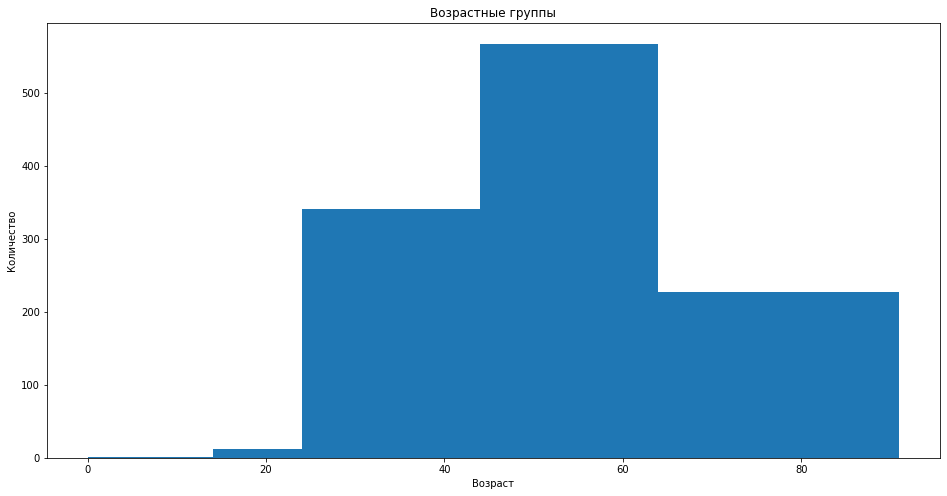

In [74]:
# Сегментация клиентов по возрасту
fig = df_clients['age'].plot.hist(figsize=(16,8),bins=[0,14,24,44,64,df_clients['age'].max()])
fig.set_title('Возрастные группы')
fig.set_xlabel('Возраст')
fig.set_ylabel('Количество')

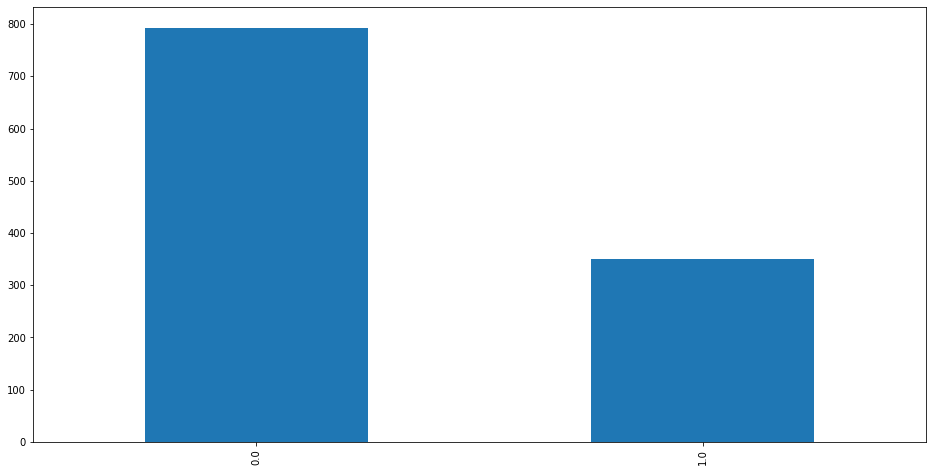

In [75]:
# Пол
df_clients['sex'].value_counts().plot.bar(figsize=(16,8))

Text(0.5, 0, 'Количество подлкючений')

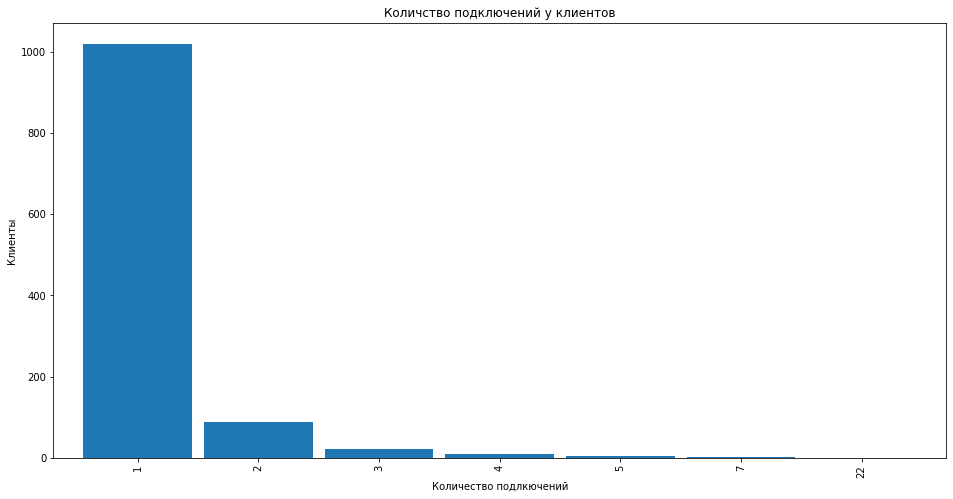

In [79]:
# Количетсво клиентов с 1,2,3.. подключенных услуг
fig = df_clients['activate_service'].value_counts().plot.bar(figsize=(16,8),width=0.9)
fig.set_title('Количство подключений у клиентов')
fig.set_ylabel('Клиенты')
fig.set_xlabel('Количество подлкючений')

Text(0.5, 0, 'Счета')

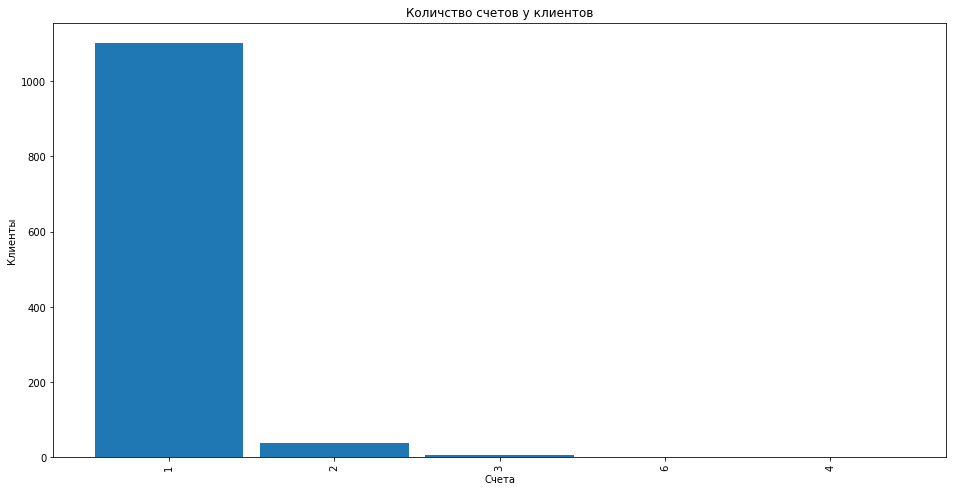

In [82]:
fig = df_clients['account_id'].value_counts().plot.bar(figsize=(16,8),width=0.9)
fig.set_title('Количство счетов у клиентов')
fig.set_ylabel('Клиенты')
fig.set_xlabel('Счета')

In [80]:
# Среднее количество счетов
df_clients['account_id'].mean()

1.050566695727986

In [83]:
# Cреднее количетво подключенных услуг
df_clients['activate_service'].mean()

1.1900610287707063

## Портрет пользователя:
Мужчина
51 год
1 счет
1 подключение услуги